In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json._normalize import nested_to_record
import json
import wandb

%matplotlib inline

## gather data df

In [2]:
username = "lavender"
project_name = "eval_threshold"
api = wandb.Api()

In [3]:
def artifact_to_df(artifact):
    local_path = artifact.file()
    f = open(local_path)
    data = json.load(f)
    df = pd.DataFrame(data=data["data"], columns=data["columns"])
    return df

In [4]:
def combine(
    trials=["temporal", "prospective", "random"],
    metrics=["fpr", "tpr"],
    artifact_names=[
        "new_temporal_auc_curve",
        "prospective_auc",
        "new_random_test_auc_curve",
    ],
):
    dfs = []
    subs = []
    for artifact_name in artifact_names:
        artifact = api.artifact(f"{username}/{project_name}/{artifact_name}:v0")
        df = artifact_to_df(artifact)
        dfs.append(df)
    for idx, artifact_df in enumerate(dfs):
        print(artifact_df)
        df_sub = artifact_df[metrics]
        df_sub["trial"] = trials[idx]
        print(df_sub)
        subs.append(df_sub)
    combined = pd.concat(subs, ignore_index=True)
    return combined

In [5]:
combined = combine()

      class    fpr    tpr
0         1  0.000  0.000
1         1  0.000  0.000
2         1  0.000  0.001
3         1  0.000  0.001
4         1  0.000  0.008
...     ...    ...    ...
9593      1  0.997  1.000
9594      1  0.997  1.000
9595      1  0.998  1.000
9596      1  0.998  1.000
9597      1  1.000  1.000

[9598 rows x 3 columns]
        fpr    tpr     trial
0     0.000  0.000  temporal
1     0.000  0.000  temporal
2     0.000  0.001  temporal
3     0.000  0.001  temporal
4     0.000  0.008  temporal
...     ...    ...       ...
9593  0.997  1.000  temporal
9594  0.997  1.000  temporal
9595  0.998  1.000  temporal
9596  0.998  1.000  temporal
9597  1.000  1.000  temporal

[9598 rows x 3 columns]
      class    fpr    tpr
0         1  0.000  0.000
1         1  0.000  0.000
2         1  0.000  0.006
3         1  0.000  0.006
4         1  0.000  0.027
...     ...    ...    ...
5177      1  0.996  1.000
5178      1  0.996  1.000
5179      1  0.997  1.000
5180      1  0.997  1.000
5181

In [6]:
df_plot = combined[combined.trial.isin(["temporal", "random"])]

In [7]:
df_plot["trial"] = df_plot["trial"].replace(
    {"random": "random-split", "temporal": "temporal-split"}
)

/tmp/ipykernel_20771/11127501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['trial'] = df_plot['trial'].replace({'random':'random-split',


In [8]:
df_plot["trial"] = pd.Categorical(
    df_plot["trial"], categories=["random-split", "temporal-split"]
)
df_plot = df_plot.sort_values(by="trial")

/tmp/ipykernel_20771/269343486.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['trial'] = pd.Categorical(df_plot['trial'],categories=['random-split', 'temporal-split'])


In [9]:
sns.set_theme(
    context="paper",
    style="white",
    palette="deep",
    font_scale=2,
    color_codes=True,
    rc=None,
)

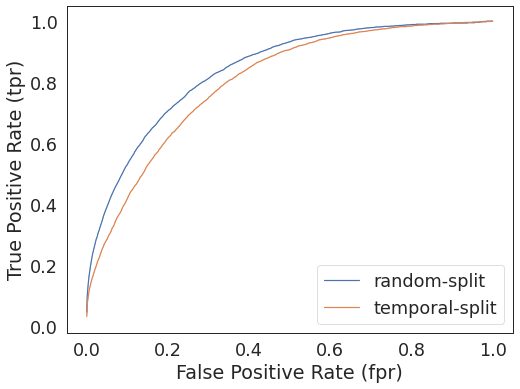

In [11]:
plt.figure(figsize=(8, 6))
sns.lineplot(x="fpr", y="tpr", data=df_plot, hue="trial")  # , ci=100)
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate (fpr)")
plt.ylabel("True Positive Rate (tpr)")
plt.savefig("AIP_plots/ext_4a.png", bbox_inches="tight", dpi=300)